<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP534-AppliedArtificialIntelligence/COMP534_CA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP 534 - Applied Artificial Intelligence
## CA3 - Image Classification with Convolutional Neural Networks
This notebook was produced as a deliverable for a group project for the above module, as part of the 2021-2022 Data Science and Artificial Intelligence MSc course at the University of Liverpool.

It comprises a performance analysis of two pre-trained CNNs. A new model is proposed to improve performance. The analysis is based on a multiclass classification problem using a dataset consisting of X-ray images of patients who are either healthy, diagnosed with covid-19, or diagnosed with pneumonia.
### Preparation
Import required libraries

In [6]:
# file handling
import os
import shutil
# matrix manipulation and data handling
import numpy as np
import pandas as pd
# creating plots
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
# monitoring training progress
from time import perf_counter
# pytorch library and utilities
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
# set random seeds for reproducibility
np.random.seed(123)
torch.manual_seed(321)
# sklearn evaluation utilities
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# use colab gpu if enabled via runtime menu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### Load dataset
Dataset downloadable from kaggle here:  
https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia - last accessed on 06/05/22

A cleaned version of the dataset was produced and can be found here:  
https://www.kaggle.com/datasets/yazanqasem/assignment - last accessed on 09/05/22

Load directly from kaggle to notebook. Note, for this to run you need to have your own kaggle API access token stored in the root directory of your Google Drive

In [1]:
# mount googledrive
from google.colab import drive
drive.mount('/content/drive')
!pip install kaggle > /dev/null
!mkdir ~/.kaggle
# copy kaggle access token from googledrive
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
# download and unzip dataset
!kaggle datasets download yazanqasem/assignment
!unzip /content/assignment.zip > /dev/null

Mounted at /content/drive
100% 2.01G/2.02G [00:54<00:00, 47.0MB/s]
100% 2.02G/2.02G [00:54<00:00, 39.5MB/s]


### Create validation split
A validation split will be taken from the training data to monitor training performance. Due to the class imbalance, the split will be stratified to maintain the same imbalance across the validation set. The train and test sets already have a constant class imbalance.

In [2]:
# define proportion of training data to be used in validation split
validSplit = 0.2

In [3]:
# create folders for validation data
!mkdir /content/Data/valid
!mkdir /content/Data/valid/COVID19/
!mkdir /content/Data/valid/NORMAL/
!mkdir /content/Data/valid/PNEUMONIA/

In [4]:
# create variables for folder path of each data split
trainFolder = '/content/Data/train/'
validFolder = '/content/Data/valid/'
testFolder = '/content/Data/test/'

In [7]:
# loop over class folders in training folder
for classFolder in os.listdir(trainFolder):    
    # count number of images
    imgCount = len(os.listdir(trainFolder+classFolder))
    # create 1d array where each element corresponds to the index of image in current folder
    imgIdxArray = np.array(range(imgCount))
    # randomly select validation split proportion of indices
    selectIdxArray = np.random.choice(imgIdxArray, int(imgCount*validSplit), replace=False)
    # loop over images in folder
    for i, imgName in enumerate(os.listdir(trainFolder+classFolder)):
        # if image index has been selected, move to validation folder
        if i in selectIdxArray:
            source = trainFolder+classFolder+'/'+imgName
            destination = validFolder+classFolder+'/'+imgName
            shutil.move(source, destination)

Confirm contents of each folder with added validation split

In [8]:
dir = '/content/Data'
# loop over folders
for folderSplit in os.listdir(dir):
    # initialise dict to count each class within splits
    folderDict = {}
    # variable to count total images in current split
    splitCount = 0
    filePath1 = dir +'/'+ folderSplit
    # loop over next level folders
    for folderClass in os.listdir(filePath1):
        filePath2 = filePath1 +'/'+ folderClass
        # count images current folder
        count = len(os.listdir(filePath2))
        # increment split count
        splitCount += count
        # store class count
        folderDict[folderClass] = count
    # print summary of counts
    print(f'{folderSplit} split contains {splitCount} images')
    for item in folderDict.items():        
        print(f'{item[0]} class: {(100 * item[1] / splitCount):.1f}%')
    print('')

test split contains 1269 images
NORMAL class: 25.0%
COVID19 class: 8.9%
PNEUMONIA class: 66.1%

valid split contains 1008 images
NORMAL class: 25.0%
COVID19 class: 8.4%
PNEUMONIA class: 66.6%

train split contains 4040 images
NORMAL class: 25.0%
COVID19 class: 8.5%
PNEUMONIA class: 66.5%



There is a class imbalance across the dataset. The imbalance is constant across each split. A class weights vector is defined in order to account for this imbalance.

In [9]:
# calculate class weights vector using validation split counts (imbalance is constant across splits)
classWeights = torch.Tensor([[(splitCount / (len(folderDict) * classCount)) for classCount in folderDict.values()]])
classWeights = nn.functional.normalize(classWeights)
classWeights = classWeights.reshape(3)
classWeights = classWeights.to(device)

### Pre-processing
All pytorch pretrained models expect the same model input. A series of transforms will be applied to ensure the input tensors are in the correct form.

In [10]:
# create transforms for use with pretrained models
transformsPretrained = transforms.Compose([
                                        # pretrained models require 3 channel input (R=G=B in this case)
                                        transforms.Grayscale(num_output_channels=3),
                                        transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])
                                        ])

### Create dataloaders
Pytorch dataloaders provide an effective method to feed data

In [11]:
# define batch size
batchSize = 64

In [12]:
# create image folder objects for each split and apply preprocessing transforms
trainData = ImageFolder(
    root=trainFolder,
    transform=transformsPretrained
    )

validData = ImageFolder(
    root=validFolder,
    transform=transformsPretrained
    )

testData = ImageFolder(
    root=testFolder,
    transform=transformsPretrained
    )

In [13]:
# create data loader objects for each split, only shuffle training split
trainDataLoader = DataLoader(
    trainData,
    batch_size=batchSize,    
    shuffle=True
    )

validDataLoader = DataLoader(
    validData,
    batch_size=batchSize,
    shuffle=False
    )

testDataLoader = DataLoader(
    testData,
    batch_size=batchSize,
    shuffle=False
    )

In [14]:
# store class label mapping
labelMap = trainData.class_to_idx

### Training
To set up the training process a number of parameters are defined.

In [15]:
# store count of number of classes
numClasses = len(labelMap)
# calculate steps per epoch for training and validation splits
trainStepsEpoch = (len(trainData) // batchSize) + 1
validStepsEpoch = (len(validData) // batchSize) + 1
# define learning rate
lr = 0.001
# define loss function
lossFunction = nn.CrossEntropyLoss(weight=classWeights)

A training function is defined for use with the pretrained models.

In [16]:
def trainer(model, epochs):
    # dictionary to store training evaluation
    history = {
        'trainLoss': [],
        'validLoss': [],
        'trainAccuracy': [],
        'validAccuracy': []
        }
    # iterate over training epochs
    for epoch in range(epochs):
        # start timer for progress monitoring
        startTime = perf_counter()
        # put model into training mode
        model.train()
        # initialise epoch evaluation metrics
        epochTrainLoss = 0
        epochValidLoss = 0
        epochTrainCorrect = 0
        epochValidCorrect = 0
        # iterate over train data batches
        for idx, (X, label) in enumerate(trainDataLoader):
            # send to gpu if available
            (X, label) = (X.to(device), label.to(device))
            # batch training cycle
            optimiser.zero_grad()
            prediction = model(X)
            loss = lossFunction(prediction, label)
            loss.backward()
            optimiser.step()           
            # increment current epoch loss and count of correct classifications
            epochTrainLoss += loss
            epochTrainCorrect += (prediction.argmax(1) == label).type(torch.float).sum().item()
            # for code development purposes only
            # if idx == 0:
            #     break
        # validation
        # disable gradient calculation
        with torch.no_grad():
            # put model in evaluation mode
            model.eval()
            # loop over validation data batches
            for idx, (X, label) in enumerate(validDataLoader):
                # send to gpu if available
                (X, label) = (X.to(device), label.to(device))
                # make the predictions
                prediction = model(X)
                # increment current epoch loss and count of correct classifications
                epochValidLoss += lossFunction(prediction, label)
                epochValidCorrect += (prediction.argmax(1) == label).type(torch.float).sum().item()
                # for code development purposes only
                # if idx == 0:
                #     break
        # calculate mean training and validation losses for epoch
        meanEpochTrainLoss = epochTrainLoss / trainStepsEpoch
        meanEpochValidLoss = epochValidLoss / validStepsEpoch
        # calculate training and validation accuracies for epoch
        trainEpochAccuracy =  100 * epochTrainCorrect / len(trainData)
        validEpochAccuracy = 100 * epochValidCorrect / len(validData)
        # store training history
        history['trainLoss'].append(meanEpochTrainLoss.cpu().detach().numpy().item())
        history['validLoss'].append(meanEpochValidLoss.cpu().detach().numpy().item())
        history['trainAccuracy'].append(trainEpochAccuracy)
        history['validAccuracy'].append(validEpochAccuracy)
        # end epoch timer
        endTime = perf_counter()
        # print summary of epoch
        print(f'Epoch: {epoch+1}. Time taken: {int((endTime-startTime)//60)}mins{int((endTime-startTime)%60)}s')
        print(f'Training loss: {meanEpochTrainLoss:.2f} --- Validation loss: {meanEpochValidLoss:.2f} --- Training accuracy: {trainEpochAccuracy:.2f}% --- Validation accuracy: {validEpochAccuracy:.2f}%')
    return history

### Testing
A tester function is defined in order to evaluate model performance.

In [17]:
def tester(model):
    # initialise array to hold results
    resultsArray = np.zeros((len(testData), 2))
    # disable gradient calculation
    with torch.no_grad():
        # put model in evaluation mode
        model.eval()
        # loop over the validation data batches
        for idx, (X, label) in enumerate(testDataLoader):
            # send input to gpu if available
            (X, label) = (X.to(device), label.to(device))
            # make predictions on inputs
            prediction = model(X)
            # store batch predictions and true labels in numpy array
            predictionNp = prediction.argmax(1).cpu().detach().numpy()
            labelNp = label.cpu().detach().numpy()
            # get start and end of current batch indices
            start = idx * batchSize
            end = (idx+1) * batchSize
            # store in results array
            resultsArray[start:end, 0] = labelNp.copy()
            resultsArray[start:end, 1] = predictionNp.copy()
            # for code development purposes only
            # if idx == 3:
            #     break
    return resultsArray

### Evaluation

In [18]:
# initialise dataframe to store metrics for each model
evaluationDf = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F-Score'])
# function to add compute metrics from results
def evaluationMetrics(modelName, resultsArray):
    return {
        'Model': modelName,
        'Accuracy': accuracy_score(resultsArray[:,0], resultsArray[:,1]),
        'Precision': precision_score(resultsArray[:,0], resultsArray[:,1], average='weighted'),
        'Recall': recall_score(resultsArray[:,0], resultsArray[:,1], average='weighted'),        
        'F-Score': f1_score(resultsArray[:,0], resultsArray[:,1], average='weighted')
    }

### VGG11 pretrained model

In [19]:
# load pretrained vgg11 model
vgg11 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)
# set all parameters to be fixed
for parameter in vgg11.parameters():
	parameter.requires_grad = False
# modify last layer to have required number of outputs
vgg11.classifier[-1] = nn.Linear(vgg11.classifier[-1].in_features, numClasses)
# send model to gpu if available
vgg11 = vgg11.to(device)
# initialise optimiser for training the output layer weights only
optimiser = torch.optim.Adam(vgg11.classifier[-1].parameters(), lr=lr)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Training

In [20]:
# train model and store training history
vgg11History = trainer(vgg11, 10)

Epoch: 1. Time taken: 3mins49s
Training loss: 0.37 --- Validation loss: 0.32 --- Training accuracy: 74.65% --- Validation accuracy: 86.61%
Epoch: 2. Time taken: 3mins47s
Training loss: 0.25 --- Validation loss: 0.39 --- Training accuracy: 83.59% --- Validation accuracy: 82.94%
Epoch: 3. Time taken: 3mins46s
Training loss: 0.24 --- Validation loss: 0.27 --- Training accuracy: 83.84% --- Validation accuracy: 88.69%
Epoch: 4. Time taken: 3mins46s
Training loss: 0.21 --- Validation loss: 0.23 --- Training accuracy: 86.01% --- Validation accuracy: 91.77%
Epoch: 5. Time taken: 3mins45s
Training loss: 0.21 --- Validation loss: 0.29 --- Training accuracy: 86.53% --- Validation accuracy: 88.49%
Epoch: 6. Time taken: 3mins45s
Training loss: 0.21 --- Validation loss: 0.29 --- Training accuracy: 87.15% --- Validation accuracy: 87.80%
Epoch: 7. Time taken: 3mins44s
Training loss: 0.20 --- Validation loss: 0.25 --- Training accuracy: 87.20% --- Validation accuracy: 89.48%
Epoch: 8. Time taken: 3mins

In [63]:
# create dataframe from results dictionary
df = pd.DataFrame(vgg11History)
df = df.reset_index()
df = df.rename(columns={'index':'Epoch'})
# change results to a long form for plotting
dfLoss = df.rename(columns={'trainLoss':'Training',	'validLoss':'Validation'})
dfLoss = pd.melt(
    dfLoss,
    id_vars=['Epoch'],
    value_vars=['Training', 'Validation'],
    var_name='Split',
    value_name='Loss',)

dfAcc = df.rename(columns={'trainAccuracy':'Training',	'validAccuracy':'Validation'})
dfAcc = pd.melt(dfAcc,
                 id_vars=['Epoch'],
                 value_vars=['Training', 'Validation'],
                var_name='Split',
                 value_name='Accuracy (%)',)

dfLoss = dfLoss.set_index(['Split', 'Epoch'])
dfLong = dfAcc.copy()
# join loss and accuracy long form dataframes back together
dfLong = dfLong.join(dfLoss, on=['Split', 'Epoch'])

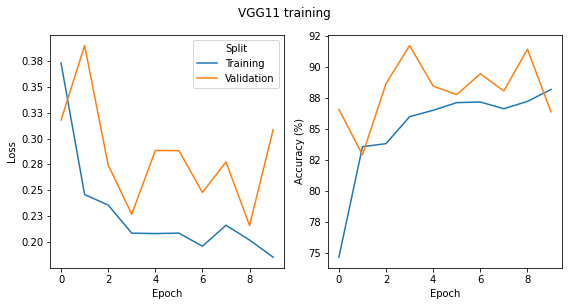

In [64]:
# create training performance figure
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# plot loss
sns.lineplot(ax=axs[0], data=dfLong, x='Epoch', y='Loss', hue='Split')
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plot accuracy
sns.lineplot(ax=axs[1], data=dfLong, x='Epoch', y='Accuracy (%)', hue='Split')
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axs[1].get_legend().remove()

fig.tight_layout()
# add title
fig.suptitle('VGG11 training', y=1.05, fontsize=12)

fig.savefig('vgg11Training', bbox_inches='tight')
plt.show()

Testing

In [34]:
# test model and store results
vgg11Results = tester(vgg11)

Evaluation

In [35]:
labelList = [key for key in labelMap.keys()]
labelList

['COVID19', 'NORMAL', 'PNEUMONIA']

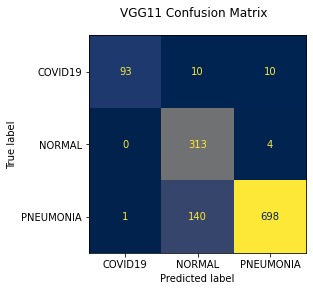

In [38]:
# create figure for confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
# create confusion matrix display
vgg11CM = ConfusionMatrixDisplay(    
    confusion_matrix=confusion_matrix(vgg11Results[:,0],vgg11Results[:,1]),
    display_labels=labelList)
# plot confusion matrix
vgg11CM.plot(ax=ax,
             colorbar=False,
             cmap='cividis')

# add title
fig.suptitle('VGG11 Confusion Matrix', fontsize=12)

fig.savefig('vgg11ConfMat', bbox_inches='tight')
plt.show()

In [37]:
evaluationDf = evaluationDf.append(evaluationMetrics('VGG11', vgg11Results), ignore_index=True)
evaluationDf

,Model,Accuracy,Precision,Recall,F-Score
0,VGG11,0.869976,0.905123,0.869976,0.875574


### GoogleNet pretrained model

In [39]:
# load pretrained GoogleNet model
googleNet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
# set all parameters to be fixed
for parameter in googleNet.parameters():
	parameter.requires_grad = False
# modify last layer to have required number of outputs
googleNet.fc = nn.Linear(googleNet.fc.in_features, numClasses)
# send model to gpu if available
googleNet = googleNet.to(device)
# initialise optimiser for training the output layer weights only
optimiser = torch.optim.Adam(googleNet.fc.parameters(), lr=lr)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

Training

In [40]:
# train model and store training history
googleNetHistory = trainer(googleNet, 10)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch: 1. Time taken: 3mins40s
Training loss: 0.62 --- Validation loss: 0.68 --- Training accuracy: 45.77% --- Validation accuracy: 66.96%
Epoch: 2. Time taken: 3mins41s
Training loss: 0.38 --- Validation loss: 0.37 --- Training accuracy: 73.94% --- Validation accuracy: 87.40%
Epoch: 3. Time taken: 3mins42s
Training loss: 0.29 --- Validation loss: 0.37 --- Training accuracy: 80.82% --- Validation accuracy: 86.11%
Epoch: 4. Time taken: 3mins42s
Training loss: 0.26 --- Validation loss: 0.31 --- Training accuracy: 83.17% --- Validation accuracy: 88.49%
Epoch: 5. Time taken: 3mins41s
Training loss: 0.24 --- Validation loss: 0.35 --- Training accuracy: 85.45% --- Validation accuracy: 87.40%
Epoch: 6. Time taken: 3mins41s
Training loss: 0.24 --- Validation loss: 0.38 --- Training accuracy: 84.88% --- Validation accuracy: 84.62%
Epoch: 7. Time taken: 3mins42s
Training loss: 0.22 --- Validation loss: 0.27 --- Training accuracy: 85.69% --- Validation accuracy: 89.98%
Epoch: 8. Time taken: 3mins

In [61]:
# create dataframe from results dictionary
df = pd.DataFrame(googleNetHistory)
df = df.reset_index()
df = df.rename(columns={'index':'Epoch'})
# change results to a long form for plotting
dfLoss = df.rename(columns={'trainLoss':'Training',	'validLoss':'Validation'})
dfLoss = pd.melt(
    dfLoss,
    id_vars=['Epoch'],
    value_vars=['Training', 'Validation'],
    var_name='Split',
    value_name='Loss',)

dfAcc = df.rename(columns={'trainAccuracy':'Training',	'validAccuracy':'Validation'})
dfAcc = pd.melt(dfAcc,
                 id_vars=['Epoch'],
                 value_vars=['Training', 'Validation'],
                var_name='Split',
                 value_name='Accuracy (%)',)

dfLoss = dfLoss.set_index(['Split', 'Epoch'])
dfLong = dfAcc.copy()
# join loss and accuracy long form dataframes back together
dfLong = dfLong.join(dfLoss, on=['Split', 'Epoch'])

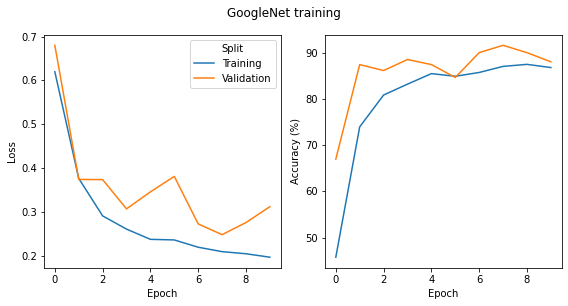

In [62]:
# create training performance figure
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# plot loss
sns.lineplot(ax=axs[0], data=dfLong, x='Epoch', y='Loss', hue='Split')
# plot accuracy
sns.lineplot(ax=axs[1], data=dfLong, x='Epoch', y='Accuracy (%)', hue='Split')
axs[1].get_legend().remove()

fig.tight_layout()
# add title
fig.suptitle('GoogleNet training', y=1.05, fontsize=12)

fig.savefig('googleNetTraining', bbox_inches='tight')
plt.show()            

Testing

In [44]:
# test model and store results
googleNetResults = tester(googleNet)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Evaluation

In [45]:
# labelList = [key for key in labelMap.keys()]
labelList

['COVID19', 'NORMAL', 'PNEUMONIA']

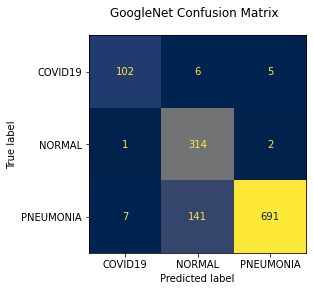

In [47]:
# create figure for confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
# create confusion matrix display
gNetCM = ConfusionMatrixDisplay(    
    confusion_matrix=confusion_matrix(googleNetResults[:,0],googleNetResults[:,1]),
    display_labels=labelList)
# plot confusion matrix
gNetCM.plot(ax=ax,
             colorbar=False,
             cmap='cividis')

# add title
fig.suptitle('GoogleNet Confusion Matrix', fontsize=12)

fig.savefig('googleNetConfMat', bbox_inches='tight')
plt.show()

In [48]:
evaluationDf = evaluationDf.append(evaluationMetrics('GoogleNet', googleNetResults), ignore_index=True)
evaluationDf

,Model,Accuracy,Precision,Recall,F-Score
0,VGG11,0.869976,0.905123,0.869976,0.875574
1,GoogleNet,0.872340,0.907238,0.872340,0.877576


### Improved model

In [ ]:
# load pretrained vgg11 model
vgg11Mod = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11_bn', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

In [ ]:
# define a new classifier
vggModClassifier = nn.Sequential(
	nn.Linear(vgg11Mod.classifier[0].in_features, 6272),
	nn.ReLU(),
	nn.Dropout(0.25),
	nn.Linear(6272, 1568),
	nn.ReLU(),
	nn.Dropout(0.25),
    nn.Linear(1568, 382),
	nn.ReLU(),
	nn.Dropout(0.25),
    nn.Linear(382, 96),
	nn.ReLU(),
	nn.Dropout(0.25),
    nn.Linear(96, 24),
	nn.ReLU(),
	nn.Dropout(0.25),    
	nn.Linear(24, 3),
    # nn.Softmax()
)

In [ ]:
vgg11Mod.classifier = vggModClassifier

In [ ]:
for module, param in zip(vgg11Mod.modules(), vgg11Mod.parameters()):
	if isinstance(module, nn.BatchNorm2d):
		param.requires_grad = False

In [ ]:
# send model to gpu if available
vgg11Mod = vgg11Mod.to(device)
# initialise optimiser for training
optimiser = torch.optim.Adam(vgg11Mod.parameters())

Train

In [ ]:
# train model and store training history
vgg11ModHistory = trainer(vgg11Mod, 3)

Epoch: 1. Time taken: 4mins14s
Training loss: 0.60 --- Validation loss: 0.49 --- Training accuracy: 62.40% --- Validation accuracy: 81.45%
Epoch: 2. Time taken: 4mins14s
Training loss: 0.43 --- Validation loss: 0.44 --- Training accuracy: 75.79% --- Validation accuracy: 81.05%
Epoch: 3. Time taken: 4mins13s
Training loss: 0.36 --- Validation loss: 0.34 --- Training accuracy: 79.75% --- Validation accuracy: 87.20%


In [ ]:
# create dataframe from results dictionary
df = pd.DataFrame(vgg11ModHistory)
df = df.reset_index()
df = df.rename(columns={'index':'Epoch'})
# change results to a long form for plotting
dfLoss = df.rename(columns={'trainLoss':'Training',	'validLoss':'Validation'})
dfLoss = pd.melt(
    dfLoss,
    id_vars=['Epoch'],
    value_vars=['Training', 'Validation'],
    var_name='Split',
    value_name='Loss',)

dfAcc = df.rename(columns={'trainAccuracy':'Training',	'validAccuracy':'Validation'})
dfAcc = pd.melt(dfAcc,
                 id_vars=['Epoch'],
                 value_vars=['Training', 'Validation'],
                var_name='Split',
                 value_name='Accuracy (%)',)

dfLoss = dfLoss.set_index(['Split', 'Epoch'])
dfLong = dfAcc.copy()
# join loss and accuracy long form dataframes back together
dfLong = dfLong.join(dfLoss, on=['Split', 'Epoch'])

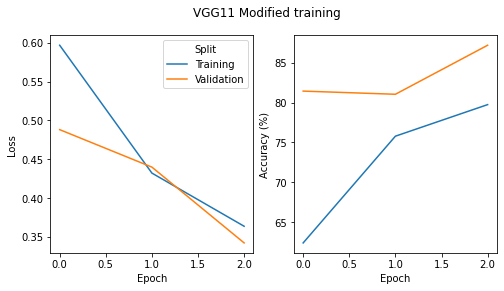

In [ ]:
# create training performance figure
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# plot loss
sns.lineplot(ax=axs[0], data=dfLong, x='Epoch', y='Loss', hue='Split')
# plot accuracy
sns.lineplot(ax=axs[1], data=dfLong, x='Epoch', y='Accuracy (%)', hue='Split')
axs[1].get_legend().remove()
# add title
fig.suptitle('VGG11 Modified training', fontsize=12)

fig.savefig('VGG11ModTraining', bbox_inches='tight')
plt.show()  

Test

In [ ]:
# test model and store results
vgg11ModResults = tester(vgg11Mod)

Evaluation

In [ ]:
labelList = [key for key in labelMap.keys()]
labelList

['COVID19', 'NORMAL', 'PNEUMONIA']

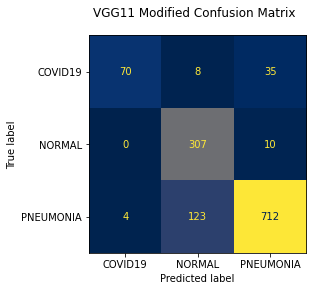

In [ ]:
# create figure for confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
# create confusion matrix display
vgg11ModCM = ConfusionMatrixDisplay(    
    confusion_matrix=confusion_matrix(vgg11ModResults[:,0], vgg11ModResults[:,1]),
    display_labels=labelList)
# plot confusion matrix
vgg11ModCM.plot(ax=ax,
             colorbar=False,
             cmap='cividis')

# add title
fig.suptitle('VGG11 Modified Confusion Matrix', fontsize=12)

# fig.savefig('vgg11ModConfMat', bbox_inches='tight')
plt.show()

In [ ]:
evaluationDf = evaluationDf.append(evaluationMetrics('VGG11 Modified', vgg11ModResults), ignore_index=True)
evaluationDf